# TFM. Modelos basados en redes neuronales profundas para predecir la edición de ARNm

## Módulos Python

Utilizaremos la librería Keras integrada en Tensorflow

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, precision_score, cohen_kappa_score, classification_report
import seaborn as sns; sns.set()
from keras import backend as K

In [2]:
########################################
# PARAMS
########################################
padding=True
model_name = 'TFM_LSTMBidiAttention_400K'
fname = 'hg38_RS_DL_Pad_W50_BALANCED_1_1_CODED_REDUCED.csv'
data_origin = 'ALL_HG38/W50'
samples_for_train_and_val =  400000
samples_for_test          =  400000
num_lstm_units=256
n_epochs=40
batch_size=32
dropout_value=0.2
categories_size=20
#########################################

## Configuración de los entornos posibles de ejecución.

Los dos entornos posibles de ejecución son Google Colab Pro y Jupyter Lab.

In [3]:
#CHECK GOOGLE COLAB
GOOGLE_COLAB=False
if 'google.colab' in str(get_ipython()):
  GOOGLE_COLAB=True  
  print('Running on CoLab')
else:
  print('Not running on CoLab')

Running on CoLab


Chequeamos la disponibilidad de GPU.

In [4]:
#CHECK GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Num GPUs Available: {}'.format(len(tf.config.list_physical_devices('GPU'))))
  print('Found GPU at: {}'.format(device_name))
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
     print('Not connected to a GPU')
  else:
     print(gpu_info)


Num GPUs Available: 1
Found GPU at: /device:GPU:0
Sun May 22 15:57:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    27W /  70W |    264MiB / 15109MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                      

## Configuración e inicialización de parámetros.

In [5]:

if padding==True:
    categories_size=21    
#----------------------------------------   
if GOOGLE_COLAB==False:
    data_dir = '../data/datasets/'+ data_origin
    models_dir = './SAVED_MODELS'

else:
    from google.colab import drive
    drive.mount('/content/drive')
    root_dir = '/content/drive/MyDrive/'
    import sys
    sys.path.insert(0,root_dir+'ColabNotebooks') #to add additional modules  
    data_dir  = root_dir + 'DATASETS/' + data_origin
    models_dir= root_dir + 'MODELS'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#MODELS
best_model = 'best_model_'+model_name+'.h5'
last_model =  model_name+'.h5'

lastmodelfile = os.path.join(models_dir, last_model)
print("LAST MODEL FILE: {}".format(lastmodelfile))
bestmodelfile = os.path.join(models_dir, best_model)
print("BEST MODEL FILE: {}".format(bestmodelfile))
datafile = os.path.join(data_dir, fname)

LAST MODEL FILE: /content/drive/MyDrive/MODELS/TFM_LSTMBidiAttention_400K.h5
BEST MODEL FILE: /content/drive/MyDrive/MODELS/best_model_TFM_LSTMBidiAttention_400K.h5


In [7]:
#LOAD DATASET
print("DATASET: {}".format(datafile))
dataraw = pd.read_csv(datafile,sep=";")
print("shape dataraw={}".format(dataraw.shape))

DATASET: /content/drive/MyDrive/DATASETS/ALL_HG38/W50/hg38_RS_DL_Pad_W50_BALANCED_1_1_CODED_REDUCED.csv
shape dataraw=(8644348, 104)


Dividimos todos los datos en dos grupos aleatorios de igual longitud.
El primer grupo será el grupo del que extraigamos los datos para entrenar el modelo y el segundo grupo será para extraer los datos para test.
Así garantizamos que no haya repeticiones.

In [8]:
X=dataraw.iloc[:,3:]
Y=dataraw['EDITING']
del dataraw #free memory

#Split data in two halves: 
#Set1 as a pool for model training and validation
#Set2 as a pool for testing
random_seed=2022
x_set1, x_set2, y_set1, y_set2 = train_test_split(X, Y, test_size=0.5, random_state=random_seed)
del X
del Y
print("x_set1:{} y_set1:{}".format(x_set1.shape,y_set1.shape))
print("x_set2:{} y_set2:{}".format(x_set2.shape,y_set2.shape))



x_set1:(4322174, 101) y_set1:(4322174,)
x_set2:(4322174, 101) y_set2:(4322174,)


Del primer grupo extraemos 400.000 muestras para entrenamiento y test.

In [9]:
#Pool for Training and Validation: Set1 -> Set3
#---------------------------------------------------------------------- 
random_seed=2022
fraction_for_train_and_val=samples_for_train_and_val/(x_set1.shape[0])
print("fraction_for_train_and_val={}".format(fraction_for_train_and_val))
x_out, x_set3, y_out, y_set3 = train_test_split(x_set1, y_set1, 
                                                test_size=fraction_for_train_and_val, 
                                                random_state=random_seed)
#free memory
del x_set1
del y_set1

print("x_set3.shape={}".format(x_set3.shape))
print("y_set3.shape={}".format(y_set3.shape))
print("SET3 TEST LABELS:")
print(y_set3.value_counts())

#Data for Training and Validation: Set3 -> Train and Val
#---------------------------------------------------------------------- 
random_seed=2022
x_train, x_val, y_train, y_val = train_test_split(x_set3, y_set3, 
                                                test_size=0.25, 
                                                random_state=random_seed)
#free memory
del x_set3
del y_set3

print("x_train.shape={}".format(x_train.shape))
print("y_train.shape={}".format(y_train.shape))
print("x_val.shape={}".format(x_val.shape))
print("y_val.shape={}".format(y_val.shape))
print("TRAIN LABELS:")
print(y_train.value_counts())
print("VALIDATION LABELS:")
print(y_val.value_counts())

fraction_for_train_and_val=0.09254601966510372
x_set3.shape=(400000, 101)
y_set3.shape=(400000,)
SET3 TEST LABELS:
0    200025
1    199975
Name: EDITING, dtype: int64
x_train.shape=(300000, 101)
y_train.shape=(300000,)
x_val.shape=(100000, 101)
y_val.shape=(100000,)
TRAIN LABELS:
0    150185
1    149815
Name: EDITING, dtype: int64
VALIDATION LABELS:
1    50160
0    49840
Name: EDITING, dtype: int64


Del segundo grupo extraemos 1.000.000 de muestras para test.

In [10]:
#Data for testing predictions: Set2 -> Test
#---------------------------------------------------------------------- 
random_seed=2022
fraction_for_test=samples_for_test/(x_set2.shape[0])
print("fraction_for_test={}".format(fraction_for_test))
x_out, x_test, y_out, y_test = train_test_split(x_set2, y_set2, 
                                                test_size=fraction_for_test, 
                                                random_state=random_seed)
#free memory
del x_set2
del y_set2

print("x_test.shape={}".format(x_test.shape))
print("y_test.shape={}".format(y_test.shape))
print("TEST LABELS:")
print(y_test.value_counts())

fraction_for_test=0.09254601966510372
x_test.shape=(400000, 101)
y_test.shape=(400000,)
TEST LABELS:
0    200125
1    199875
Name: EDITING, dtype: int64


In [11]:
#DataGenerator converts on the fly from raw data to one-hot
from RNAEd import DataGenerator

num_nucleosides = x_train.shape[1]
num_tokens = categories_size

training_generator   = DataGenerator(x_train, y_train, batch_size=batch_size, seq_size=num_nucleosides, categories_size=categories_size, shuffle=True)
validation_generator = DataGenerator(x_val,   y_val,   batch_size=batch_size, seq_size=num_nucleosides, categories_size=categories_size, shuffle=True)
test_generator       = DataGenerator(x_test,  y_test,  batch_size=1,seq_size=num_nucleosides, categories_size=categories_size, shuffle=False )

## Attention Layer

In [12]:
from keras.layers import *
from keras.models import *
from keras import backend as K

class attention(Layer):
    ''' heredamos de la clase layer '''
    def __init__(self):
        super(attention,self).__init__()
    
    #En el método build definimos los pesos
    def build(self, input_shape):
        # Define the shape of the weights and bias in this layer
        # The layer has just 1 lonely neuron
        
        # For convenience sake, add a couple of properties
        self.num_dim_pernucleoside = input_shape[-1] ## 1092
        self.nucleosides_persequence = input_shape[-2]  ## 41
        num_units = 1
        
        
        #Weights shape=(1092,1)
        self.W=self.add_weight(name="att_weight", shape=(self.num_dim_pernucleoside,num_units),
                               initializer="normal")
        #bias  shape=(41,1)
        self.b=self.add_weight(name="att_bias", shape=(self.nucleosides_persequence,num_units),
                               initializer="zeros")
        super(attention,self).build(input_shape)
    
    #en el método call definimos la lógica
    #esta es la implementación clásica
    def call_classic(self, x):
        # x is the input tensor of 2 x num_units=1092 dimensions
        """ We multiply the inputs ‘x’ of shape (41 * 1092) by the layer weights ‘w’ 
        of shape (1092 * 1) and obtain a (41 * 1) matrix. We add the bias (41 * 1) 
        and pass the output through any activation layer. So we now have 41 * 1 values 
        We take a softmax of these values. Softmax squashes these into values in the 
        range between 0, and 1 whose sum is 1. These are the 41 attention weights. 
        We multiply each attention weight by the respective nucleoside hidden states and sum up and we are done. 
        We now have the ‘attention adjusted output’ state ready to be fed to the next layer."""
        
        #e = K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)  # Necesario en algunos frameworks
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        # return the outputs. 'a' is the set of 41 attention weights
        # the second variable is the 'attention adjusted o/p state'
        return a, K.sum(output, axis=1)
  
    #esta implementación es más robusta
    def call(self, x):
        """ Es lo mismo de antes pero más robusto a distintos frameworks"""
        e = K.tanh(K.dot(x,self.W)+self.b)
        e = Flatten()(e)
        a = Activation('softmax')(e) 
        # Don't manipulate 'a'. It needs to be 'return'ed intact
        temp = RepeatVector(self.num_dim_pernucleoside)(a) # (?,41) becomes (?,1092,41)
        temp = Permute([2,1])(temp) # change from (?,1092,41) to (?,41,1092)
 
        output = Multiply()([x,temp])# Apply weight to each of the 1092 dim
        output = Lambda(lambda values: K.sum(values, axis=1))(output)
        return a, output

## Model defined from the scratch

In [13]:
#MODELOS REDES NEURONALES LSTM CON CAPAS DE ATENCIÓN
# Import the libraries required in this example:

num_nucleosides = x_train.shape[1]
num_tokens = categories_size
print("Number of units={}".format(num_lstm_units))
#Definimos la estructura con el Functional model
inputs = keras.Input(shape=(num_nucleosides,num_tokens), name="INPUTS")
lstm_out   = layers.Bidirectional(layers.LSTM(num_lstm_units,return_sequences=True), name="LSTM_BI")(inputs)
dropout= layers.Dropout(dropout_value)(lstm_out)

#===============================
#METHOD 1: using a custom layer:
#===============================
#La salida de la capa bidireccional será un de 1 batch=None numero de secuencas, 
#de 41 nucleosidos(timesteps) de 2xnúmero_unidades=2*546=1092
#Es decir (None,41,1092)
#---------uncomment here--------------------
#a ,att_d = attention()(dropout)
#-----------------------------
#La capa de atención debe retornarnos un peso para cada hidden state 
#correspondiente a cada elemento de la secuencia o timestep
#es decir, nos debe dar un peso por cada nuceósido, es decir, nos debe dar (41,1)
#Pero relamente no queremos esos pesos, sino la suma del vector de hidden states
#que es lo que conforma el verdadero contexto, y que tendrá dimensión (None,1,1092)
#Esta salida es lo que se llama el "attention adjusted output state".
#Para ello, nuestra capa de atención debe entrenar (1092,1) pesos, ya que debemos 
#entrenar un peso por cada dimensión del espacio vectorial del contexto.
#(1092,1) x (41,1092) = (41,1) los pesos de atención
#(1092,1) son los pesos de la capa.
#===============================================================

#===============================
#METHOD 2: using regular layers:
#===============================

#---------uncomment here--------------------
e=Dense(1, activation='tanh')(dropout)
# Now do all the softmax business taking the above o/p
e=Flatten()(e)
a=Activation('softmax')(e)
temp=RepeatVector(2*num_lstm_units)(a)
temp=Permute([2, 1])(temp)
# multiply weight with lstm layer o/p
output = merge.Multiply()([lstm_out, temp])
# Get the attention adjusted output state
att = Lambda(lambda values: K.sum(values, axis=1))(output)
#-----------------------------

#===============================================================
outputs= layers.Dense(1, activation='sigmoid', name="OUTPUT")(att)
#Creamos el modelo
model_from_scratch  = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

#Mostramos el modelo
print(model_from_scratch.summary())

Number of units=256
Model: "TFM_LSTMBidiAttention_400K"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 INPUTS (InputLayer)            [(None, 101, 21)]    0           []                               
                                                                                                  
 LSTM_BI (Bidirectional)        (None, 101, 512)     569344      ['INPUTS[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 101, 512)     0           ['LSTM_BI[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 101, 1)       513         ['dropout[0][0]']                
                                                     

In [14]:
#Compilation reset all weights
model_from_scratch.compile(optimizer=keras.optimizers.Adam(),
                           loss     =keras.losses.BinaryCrossentropy(),
                           metrics  =[keras.metrics.BinaryAccuracy()])

model=model_from_scratch

Recover last model, best model or generate a new model

In [15]:
#DataGenerator converts on the fly from raw data to one-hot
from RNAEd import DataGenerator

num_nucleosides = x_train.shape[1]
num_tokens = categories_size

training_generator   = DataGenerator(x_train, y_train, batch_size=batch_size, seq_size=num_nucleosides, categories_size=categories_size, shuffle=True)
validation_generator = DataGenerator(x_val,   y_val,   batch_size=batch_size, seq_size=num_nucleosides, categories_size=categories_size, shuffle=True)


#Load the trained model from disk
import os.path

best_model_accuracy =0
last_model_accuracy =0

if os.path.exists(bestmodelfile):
    model = tf.keras.models.load_model(bestmodelfile)
    print("Testing best model file: {}".format(bestmodelfile))
    results = model.evaluate(validation_generator,verbose=1)
    best_model_accuracy = results[1]
    print("best model accuracy: {}".format(best_model_accuracy))    

if os.path.exists(lastmodelfile):
    model = tf.keras.models.load_model(lastmodelfile)
    print("Testing last complete model file: {}".format(lastmodelfile))
    results = model.evaluate(validation_generator,verbose=1)
    last_model_accuracy = results[1]
    print("last model accuracy: {}".format(last_model_accuracy))           


if best_model_accuracy > last_model_accuracy:
   model = tf.keras.models.load_model(bestmodelfile)
   print("Selected best model saved: {}".format(bestmodelfile))
else:
  if last_model_accuracy > best_model_accuracy:
     print("Selected last model saved: {}".format(lastmodelfile))
  else:
     print("Selected new untrained model")


# Show the model architecture
model.summary()

Selected new untrained model
Model: "TFM_LSTMBidiAttention_400K"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 INPUTS (InputLayer)            [(None, 101, 21)]    0           []                               
                                                                                                  
 LSTM_BI (Bidirectional)        (None, 101, 512)     569344      ['INPUTS[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 101, 512)     0           ['LSTM_BI[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 101, 1)       513         ['dropout[0][0]']                
                                            

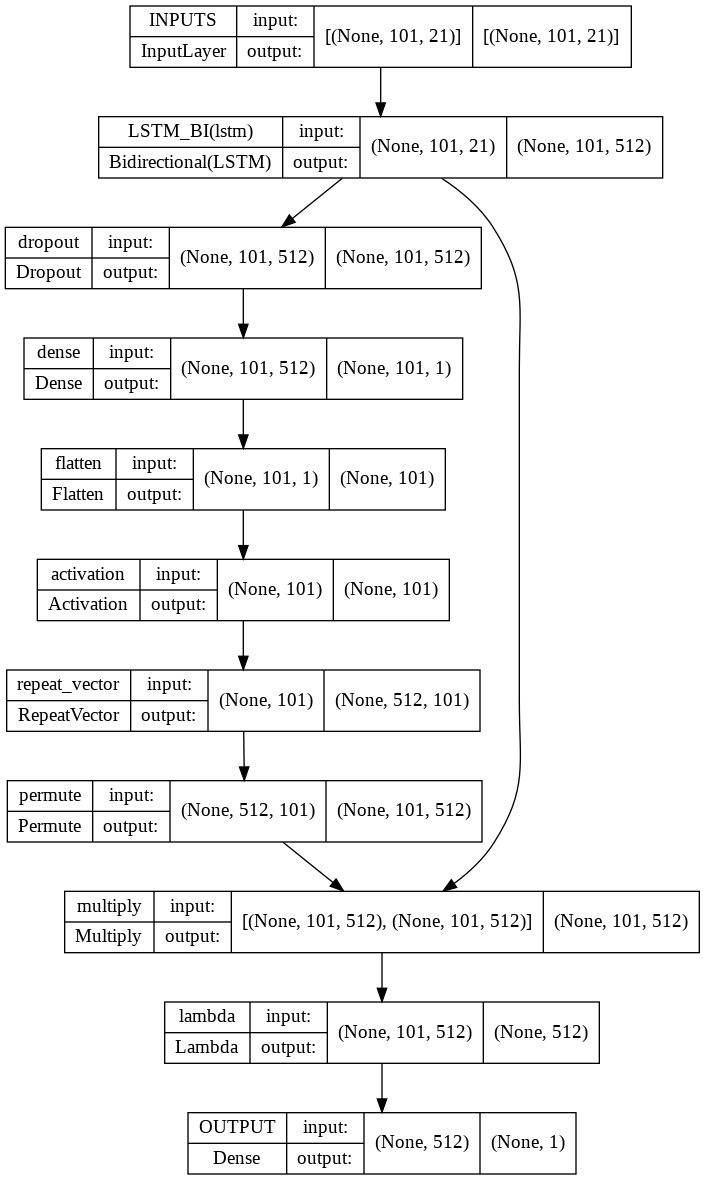

In [16]:
keras.utils.plot_model(model, show_shapes=True)

Creamos una callback especial para guardar el mejor modelo tras cada epoca.

In [17]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

callback1 = ModelCheckpoint(bestmodelfile, 
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='auto', 
                             save_freq='epoch')

callback2 =EarlyStopping(monitor='val_loss', 
                       min_delta=0, 
                       patience=3, 
                       verbose=1, 
                       mode='auto',
                       baseline=None, 
                       restore_best_weights=True)
callbacks=[callback1,callback2]

Entrenamos el modelo

In [18]:
#Train de Model
with tf.device(device_name):#Use GPU if available
    history=model.fit(training_generator,epochs=n_epochs,
                      validation_data=validation_generator,
                      callbacks=callbacks,verbose=1)

Epoch 1/40
9375/9375 [==============================] - ETA: 0s - loss: 0.3472 - binary_accuracy: 0.8698
Epoch 1: val_loss improved from inf to 0.26089, saving model to /content/drive/MyDrive/MODELS/best_model_TFM_LSTMBidiAttention_400K.h5
9375/9375 [==============================] - 1202s 127ms/step - loss: 0.3472 - binary_accuracy: 0.8698 - val_loss: 0.2609 - val_binary_accuracy: 0.9195
Epoch 2/40
9375/9375 [==============================] - ETA: 0s - loss: 0.2606 - binary_accuracy: 0.9195
Epoch 2: val_loss improved from 0.26089 to 0.25150, saving model to /content/drive/MyDrive/MODELS/best_model_TFM_LSTMBidiAttention_400K.h5
9375/9375 [==============================] - 1182s 126ms/step - loss: 0.2606 - binary_accuracy: 0.9195 - val_loss: 0.2515 - val_binary_accuracy: 0.9232
Epoch 3/40
9375/9375 [==============================] - ETA: 0s - loss: 0.2511 - binary_accuracy: 0.9237
Epoch 3: val_loss improved from 0.25150 to 0.24558, saving model to /content/drive/MyDrive/MODELS/best_mode

In [19]:
#We always save the last model.
#Last model can be triggered by early stopping
n_epochs_trained = len(history.history['loss'])
print("Trained epochs: {} of {}".format(n_epochs_trained,n_epochs))
model.save(lastmodelfile)

Trained epochs: 10 of 40


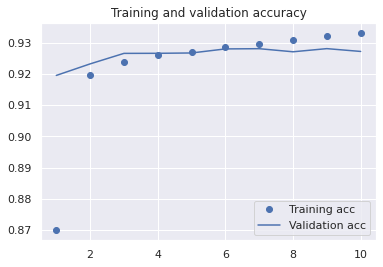

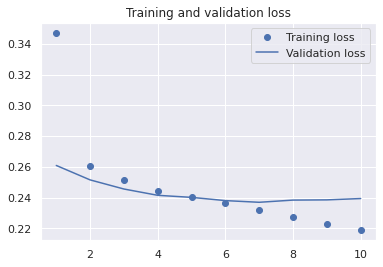

In [20]:
#PLOT ACCURACY AND LOSS

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [21]:
if os.path.exists(bestmodelfile):
    model = tf.keras.models.load_model(bestmodelfile)

In [22]:
#EVALUATE VALIDATION DATASET
print("Evaluate models on validation data")
results_model = model.evaluate(validation_generator,verbose=1)
print ('Accuracy on validation data:',round(results_model[1],3))
print ('Loss on validation data:',round(results_model[0],3))

Evaluate models on validation data
3125/3125 [==============================] - 277s 88ms/step - loss: 0.2370 - binary_accuracy: 0.9281
Accuracy on validation data: 0.928
Loss on validation data: 0.237


### PREDICCIONES

In [23]:
#PREDICTIONS
print("Make predictions on test data")
model_prediction = model.predict(test_generator,verbose=1)
model_prediction_binary = (model_prediction > 0.5).astype("int32")

Make predictions on test data
400000/400000 [==============================] - 3506s 9ms/step


In [24]:
print(x_test.shape)
print(y_test.shape)
print(model_prediction.shape)
print(model_prediction_binary.shape)

(400000, 101)
(400000,)
(400000, 1)
(400000, 1)


In [25]:
#METRICS QUALITY CLASSIFICATION
print("\nMODEL "+model_name+"\n---------------------------------")
kappa = cohen_kappa_score(y_test, model_prediction_binary)
print ('Kappa:',round(kappa,3))
print(classification_report(y_test, model_prediction_binary))


MODEL TFM_LSTMBidiAttention_400K
---------------------------------
Kappa: 0.854
              precision    recall  f1-score   support

           0       0.93      0.92      0.93    200125
           1       0.92      0.93      0.93    199875

    accuracy                           0.93    400000
   macro avg       0.93      0.93      0.93    400000
weighted avg       0.93      0.93      0.93    400000



Text(80.90000000000006, 0.5, 'Truth Editing')

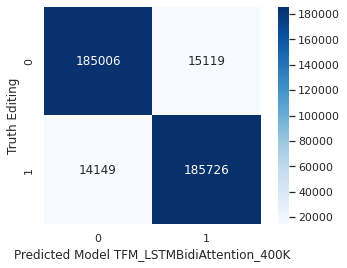

In [26]:
from sklearn.metrics import confusion_matrix, precision_score, cohen_kappa_score, classification_report
import seaborn as sns; sns.set()
# PLOT CONFUSION MATRIX
plt.figure()
cm = confusion_matrix(y_test,model_prediction_binary)
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,cmap="Blues")
plt.xlabel('Predicted Model '+ model_name)
plt.ylabel('Truth Editing')

AUC: 0.95


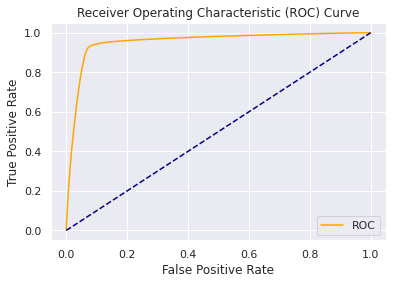

In [27]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color="orange", label="ROC")
    plt.plot([0, 1], [0, 1], color="darkblue", linestyle="--")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

auc = roc_auc_score(y_test, model_prediction)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(y_test, model_prediction)
plot_roc_curve(fpr, tpr)
